In [1]:
#This notebook inspects data for the autoencoder based analysis of the patchseq dataset.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import feather
import numpy as np
import pandas as pd
import scipy.io as sio
from data_funcs import reorder_ps_TE,extract_arrays,TEM_dataset, TEM_rem_lowsampled_classes

#Parameters
#beta_threshold controls number of genes that remain in the final list (Jeremy: use 0.2-0.4) 
#BetaScore is a measure of differential expression for each gene.
beta_threshold = 0.4

#T files: /allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse_patchseq_VISp_20191113_collapsed40_cpm/
#E files: /allen/programs/celltypes/workgroups/ivscc/nathang/spca_output/sparse_pca_components_mMET_curated_Nov11.csv
#M files: /allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Nov11_ccf_soma_locations.csv
#E features: features_met_mouse_Feb62020.csv - From Agata
pth={}

base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
pth['ref_colors']       = base_path + 'type_color_reference.csv' #Generated for inhibitory types from the FACS annotations
pth['ps_T_dat']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_data.feather'
pth['ps_T_ann']         = base_path + 'mouse_patchseq_VISp_20191113_collapsed40_cpm_anno.feather'
pth['ps_E_dat']         = base_path + 'sparse_pca_components_mMET_curated_Nov11.csv'
pth['ps_M_dat']         = base_path + 'mouse_met_Nov11_ccf_soma_locations.csv'
pth['jeremy_gene_set']  = base_path + 'good_genes_beta_score.csv'
pth['QC_cells']         = base_path + 'specimen_ids_for_paper_Nov_2019.txt'
pth['save']             = base_path

In [4]:
#Load reference colors
ref = pd.read_csv(pth['ref_colors'])

In [5]:
#Load patchseq T data and annotations
orig_dat = feather.read_dataframe(pth['ps_T_dat'])
orig_ann = feather.read_dataframe(pth['ps_T_ann'])

In [6]:
keep_cell_id = pd.read_csv(pth['QC_cells'],header=None,names=['spec_id'])
keep_gene_id = pd.read_csv(pth['jeremy_gene_set'])
keep_gene_id = keep_gene_id[keep_gene_id.BetaScore>beta_threshold]['Gene'].to_list()

In [7]:
#Restrict T data based on genes:
keepcols = ['sample_id'] + keep_gene_id
orig_dat = orig_dat[keepcols]

In [8]:
#Restrict cells to good quality cells if a cell list provided:
if keep_cell_id is not None:
    #Core + I1 + I2 + I3 cells:
    cond1 = orig_ann['Tree_call_label'].isin(['Core','I1','I2','I3'])
    cond2 = orig_ann['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
    ps_T_ann = orig_ann[cond1 & cond2].reset_index(drop=True)
    ps_T_dat = orig_dat[cond1 & cond2].reset_index(drop=True)
    assert np.array_equal(ps_T_dat['sample_id'].values,ps_T_ann['sample_id'].values),'T data and annotations are mismatched'

In [9]:
ps_T_dat.shape

(3411, 1253)

In [10]:
#cluster_labels are now called topLeaf_label. Colors are determined from the facs reference:
ps_T_ann['cluster_label'] = ps_T_ann['topLeaf_label'].values
ps_T_ann['cluster_id'] = ps_T_ann['topLeaf_id'].values
ps_T_ann['map_conf'] = ps_T_ann['Tree_call_label'].values

#Delete the color annotations in the patchseq file, and replace with FACS reference colors
del ps_T_ann['cluster_color']
ps_T_ann = ps_T_ann.join(ref.set_index('celltype'),on='cluster_label') 

In [11]:
#Load E data
orig_E_dat = pd.read_csv(pth['ps_E_dat'])
orig_E_dat.rename(columns = {orig_E_dat.columns[0]: 'spec_id_label'}, inplace=True)
cond1 = orig_E_dat['spec_id_label'].isin(keep_cell_id['spec_id'].values.astype(str))
ps_E_dat = orig_E_dat[cond1]

In [12]:
ps_Tcat_dat, ps_Tcat_ann, ps_Ecat_dat, ispairedT, ispairedE = reorder_ps_TE(ps_T_dat,ps_T_ann,ps_E_dat)
matdict = extract_arrays(ps_Tcat_dat, ps_Tcat_ann, ispairedT, ps_Ecat_dat, ispairedE, keep_gene_id)

-----------------------------------------------
0 exclusive, 3411 matched, total 3411 in T
-----------------------------------------------
297 exclusive, 3411 matched, total 3708 in E


In [13]:
#Core and I1 map confidently to a single leaf node
#I2 and I3 have good quality transcriptomic data, but unreliable mapping results
pd.Series(matdict['map_conf']).value_counts().to_frame(name='counts')

,counts
Core,1965
I1,780
I2,602
I3,64


**Counts of sampled transcriptomic types**

In [14]:
X = ps_Tcat_ann['cluster_label'].value_counts().to_frame()
X.rename(columns={'cluster_label': 'counts'},inplace=True)
Y = ps_Tcat_ann[['cluster_id','cluster_label','cluster_color']].drop_duplicates().sort_values(by='cluster_label').reset_index(drop=True)
X = Y.set_index('cluster_label').join(X).reset_index()

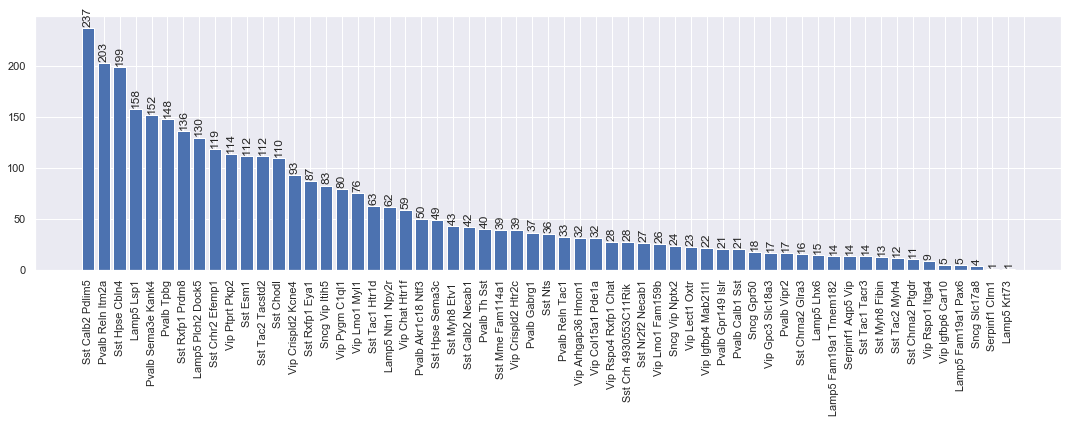

In [15]:
X = X.sort_values(by='counts',ascending=False).reset_index()
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color='b')
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
from analysis_tree_helpers import HTree
htree_filename = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
htree = HTree(htree_file=htree_filename)
htree_df = htree.obj2df()

X = X.merge(right=htree_df,how='left',left_on='cluster_label',right_on='child')
X = X[['cluster_label','cluster_color','counts','x']]
X = X.sort_values(by='x')
X.reset_index(drop=True,inplace=True)

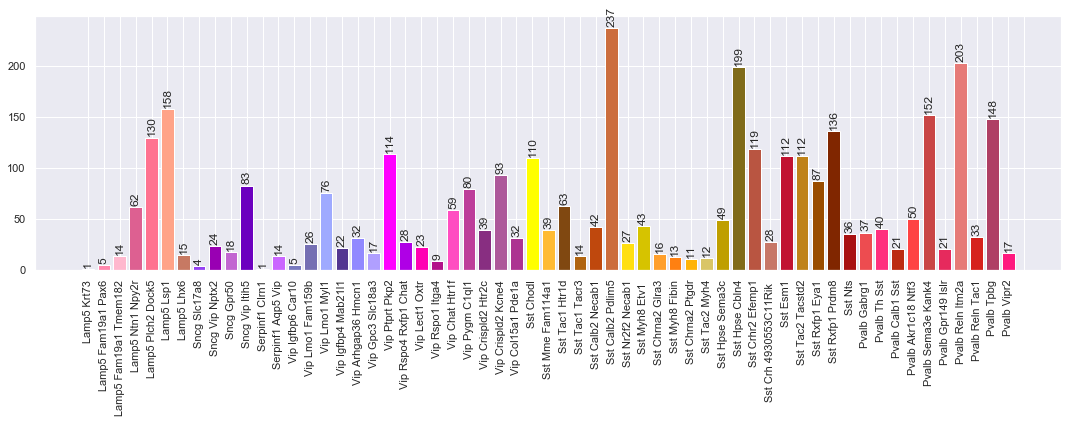

In [17]:
fig = plt.figure(figsize = (15,6))
for i in np.arange(X['counts'].values.size):
    plt.bar(x=i,height=X['counts'].values[i],color=X['cluster_color'].values[i])
    plt.text(i,X['counts'].values[i]+3,str(X['counts'].values[i]),rotation = 90,horizontalalignment='center')
ax = plt.gca()           
ax.set_xticks(np.arange(0,60,1))
ax.set_xticklabels(X['cluster_label'].values, rotation=90)
plt.tight_layout()
plt.show()

**Electrophysiology feature-wise distributions**

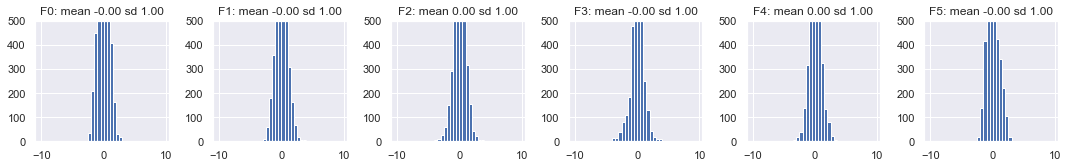

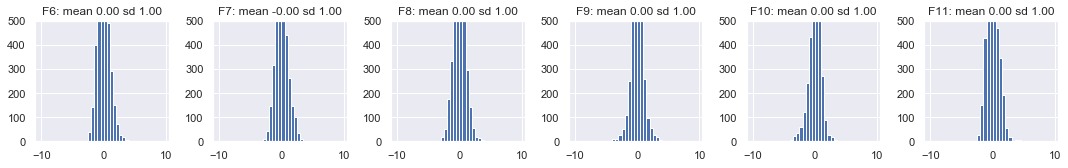

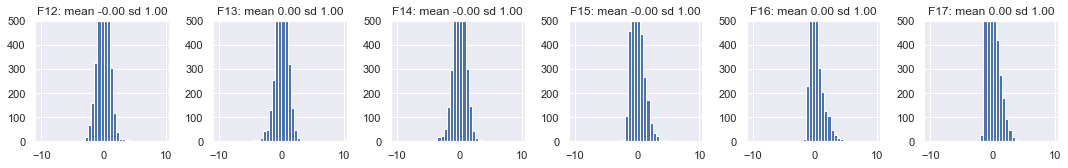

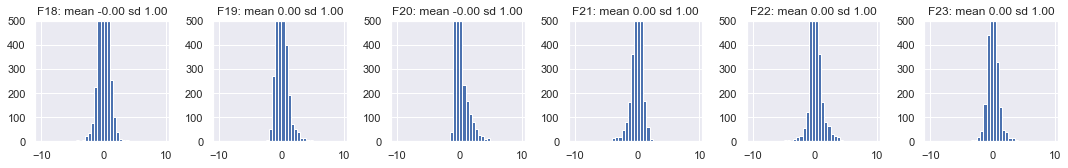

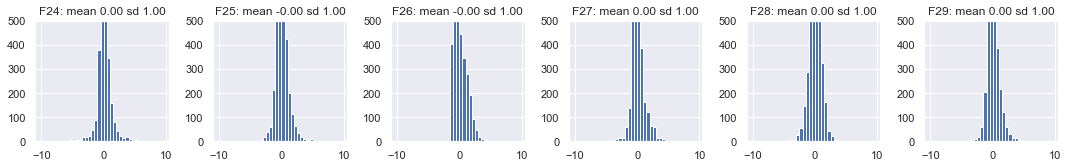

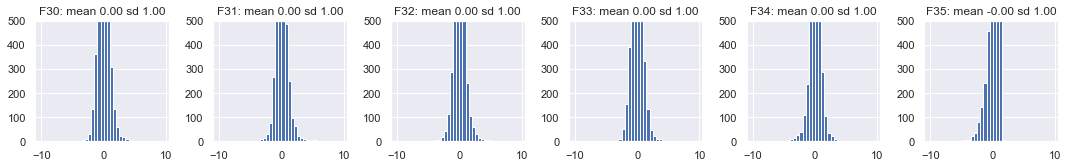

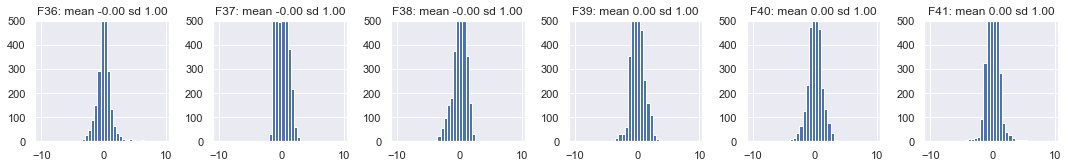

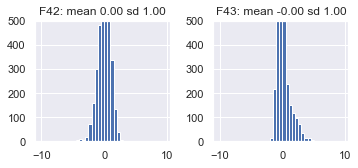

In [18]:
matdict['E_dat'].shape
nplots_perline = 6
for i in range(matdict['E_dat'].shape[1]):
    if i%nplots_perline==0:
        plt.figure(figsize = (15,2.5))
    plt.subplot(1,nplots_perline,i%nplots_perline+1)
    ax = plt.gca()
    ax.set_title('F{:d}: mean {:.2f} sd {:.2f}'.format(i,np.mean(matdict['E_dat'][:,i]),np.std(matdict['E_dat'][:,i])))
    ax.set_ylim(0,500)
    counts=plt.hist(matdict['E_dat'][:,i],np.arange(-10,10,0.5))
    bins = counts[1]
    bins = (bins[0:-1]+bins[1:])/2
    counts = counts[0]

    #for j in range(bins.size):
    #    plt.text(bins[j],counts[j],str(counts[j]),rotation = 90,horizontalalignment='center')
    plt.tight_layout()

**Inspect and remove sPC outliers**

In [19]:
all_outliers = np.zeros((matdict['E_dat'].shape[0],), dtype=bool)
for i in range(matdict['E_dat'].shape[1]):
    outlier_ind = np.abs(matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i]))>6*np.std(matdict['E_dat'][:,i])
    outliers = np.sum(outlier_ind)
    if outliers>0:
        print('{:3d} outliers in feature {:d}'.format(outliers,i))
    all_outliers = np.logical_or(all_outliers,outlier_ind)

print('\n')
outlier_inds = np.flatnonzero(all_outliers)
paired_outlier_inds = outlier_inds[matdict['E_ispaired'][outlier_inds]==1]
print(pd.Series(np.sort(matdict['cluster'][paired_outlier_inds])).value_counts())

  1 outliers in feature 10
  2 outliers in feature 12
  1 outliers in feature 16
  8 outliers in feature 18
  3 outliers in feature 19
  3 outliers in feature 20
  4 outliers in feature 21
  6 outliers in feature 22
  2 outliers in feature 23
  9 outliers in feature 24
  1 outliers in feature 25
  1 outliers in feature 26
  3 outliers in feature 27
  4 outliers in feature 29
  4 outliers in feature 31
  3 outliers in feature 34
  2 outliers in feature 35
 15 outliers in feature 36
  1 outliers in feature 41


Vip Crispld2 Kcne4    4
Lamp5 Plch2 Dock5     4
Pvalb Sema3e Kank4    3
Sst Hpse Cbln4        3
Vip Ptprt Pkp2        3
Sst Chrna2 Glra3      3
Pvalb Gabrg1          3
Vip Arhgap36 Hmcn1    3
Sst Chrna2 Ptgdr      2
Vip Crispld2 Htr2c    2
Pvalb Tpbg            2
Sst Chodl             2
Pvalb Reln Itm2a      2
Vip Lmo1 Myl1         2
Sst Tac2 Tacstd2      1
Vip Igfbp4 Mab21l1    1
Pvalb Th Sst          1
Sst Crhr2 Efemp1      1
Pvalb Akr1c18 Ntf3    1
Sst Calb2 Pdlim5      1
Sst M

**Removing sPC feature outliers**

Outliers are detected on a per feature basis. sPCs are z-scored already.

In [20]:
#Set values beyond the 6 sigma in either direction to the boundary.
for i in range(matdict['E_dat'].shape[1]):
    condition = 6*np.std(matdict['E_dat'][:,i])
    outlier_max_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) > condition
    outlier_min_ind = (matdict['E_dat'][:,i] - np.mean(matdict['E_dat'][:,i])) < -1.0*condition
    
    matdict['E_dat'][outlier_max_ind,i]=condition
    matdict['E_dat'][outlier_max_ind,i]=-1.0*condition

**Get sPC column names**

In [21]:
#Borrowing code from Nathan's notebook to rename ephys columns
import json
with open(base_path+"/spca_components_used_mMET_curated_Nov11.json") as f:
    new_comp_info = json.load(f)
new_col_lookup = {}
counter = 0
for ci in new_comp_info:
    new_col_lookup[ci["key"]] = [str(counter + i) for i, v in enumerate(ci["indices"])]
    counter += len(ci["indices"])

keys_=[]
columns_=[]
for key,value in new_col_lookup.items():
    for i,v in enumerate(value):
        keys_.append(key+'_'+str(i))
        columns_.append(v)
keys_ = np.array(keys_)
columns_ = np.array([int(c) for c in columns_])

sort_ind = np.argsort(columns_)
keys_ = keys_[sort_ind]
columns_ = columns_[sort_ind]

In [22]:
# import pprint
# pprint.pprint(list(zip(columns_,keys_)))

In [23]:
matdict['spc_name']=keys_
sio.savemat(pth['save']+'PS_v4_beta_0-4_TE_withlowconfT.mat',matdict)

**IPFX features for the patchseq dataset**

 - Contains many nans
 - Select features that aren't nan across much of the patchseq dataset
 - Standardize features after excluding outliers
 - Save transformation values
 - Use for comparison with the Tolias L4 paper features.
 - Train network with these features

In [24]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.io as sio
sns.set()

base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
matdict = sio.loadmat(base_path+'PS_v4_beta_0-4_TE_withlowconfT.mat',squeeze_me=True)
E_df = pd.read_csv(base_path+'features_met_mouse_Feb62020.csv')
E_feature_names = E_df.columns[2:]

In [25]:
mat_df = pd.DataFrame({'T_spec_id_label':matdict['T_spec_id_label'],
                       'cluster':matdict['cluster']})

#Keep E data only for cells with T measurements
E_df = mat_df.merge(E_df,how='left',left_on='T_spec_id_label',right_on='specimen_id')

 - Restrict features and samples

In [26]:
#Remove features with more nans than 10% of cells in T data
max_nans_per_feature = round(E_df.shape[0]*0.1) 
keep_features = []
for feature in E_feature_names:
    if E_df[feature].isna().sum()<max_nans_per_feature:
        keep_features.append(feature)

print('{} features kept with < {} nans'.format(len(keep_features),max_nans_per_feature))

#Remove ramp feature (not consistently measured for patch-seq cells re. Agata)
keep_features = [k for k in keep_features if 'ramp' not in k ]
E_df = E_df[['T_spec_id_label','cluster']+keep_features]

40 features kept with < 341 nans


 - Analyze number of nans per cell type

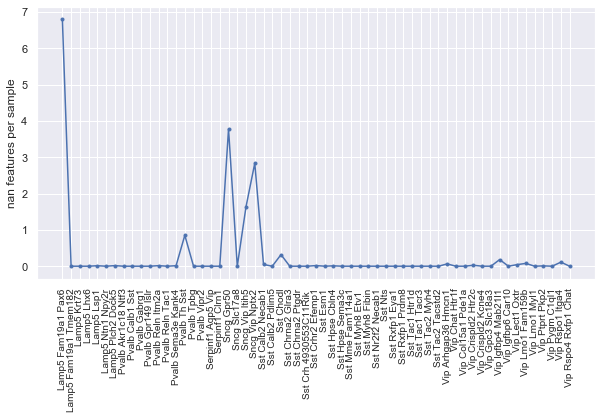

In [27]:
#Number of nans across all kept features per type
A1 = E_df.copy()
A1['nan_count']=A1.isna().sum(axis=1)
A1 = A1.groupby('cluster')['nan_count'].sum()
A1 = pd.DataFrame({'cluster':A1.index, 'nan_counts':(A1.values)})

#Number of cells per type
A2 = E_df.copy()
A2 = A2['cluster'].value_counts()
A2 = pd.DataFrame({'cluster':A2.index, 'samples':A2.values})

#Merge dataframes to inspect nans grouped by types
A = A1.merge(right=A2,left_on = 'cluster',right_on='cluster')
A['nan_ratio'] = A['nan_counts']/A['samples']

plt.figure(figsize=(10,5))
plt.plot(A['cluster'], A['nan_ratio'],'.-')
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_size(10)
ax.set_ylabel('nan features per sample')
plt.show()

In [28]:
A[A['nan_ratio']>0]

,cluster,nan_counts,samples,nan_ratio
0,Lamp5 Fam19a1 Pax6,34,5,6.800000
4,Lamp5 Lsp1,2,158,0.012658
6,Lamp5 Plch2 Dock5,2,130,0.015385
11,Pvalb Reln Itm2a,3,203,0.014778
13,Pvalb Sema3e Kank4,2,152,0.013158
14,Pvalb Th Sst,34,40,0.850000
19,Sncg Gpr50,68,18,3.777778
21,Sncg Vip Itih5,136,83,1.638554
22,Sncg Vip Nptx2,68,24,2.833333
23,Sst Calb2 Necab1,2,42,0.047619


 - Standardize features

1 outliers in ap_1_threshold_v_short_square
1 outliers in ap_1_upstroke_short_square
2 outliers in ap_1_downstroke_short_square
3 outliers in ap_1_upstroke_downstroke_ratio_short_square


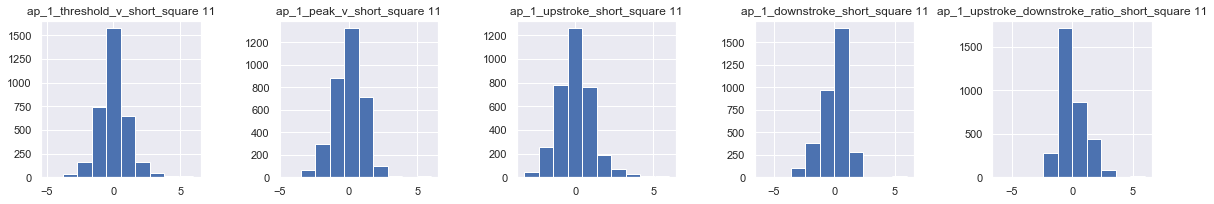

22 outliers in ap_1_width_short_square
3 outliers in ap_1_fast_trough_v_short_square
2 outliers in short_square_current
3 outliers in input_resistance
5 outliers in tau


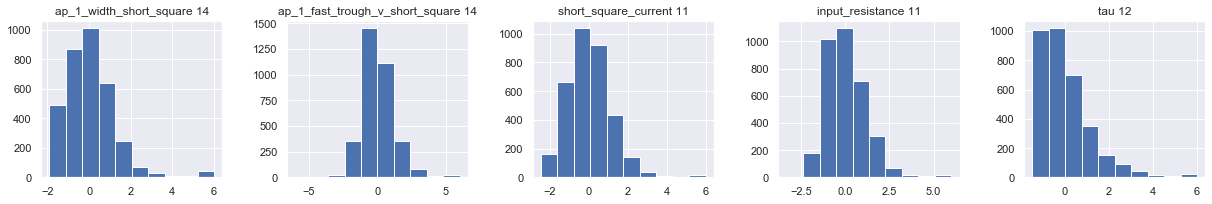

10 outliers in sag_nearest_minus_100
1 outliers in fi_linear_fit_slope


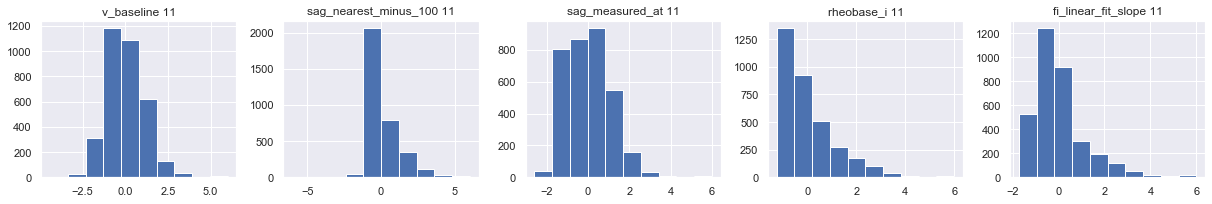

1 outliers in ap_1_threshold_v_0_long_square
3 outliers in ap_1_upstroke_downstroke_ratio_0_long_square


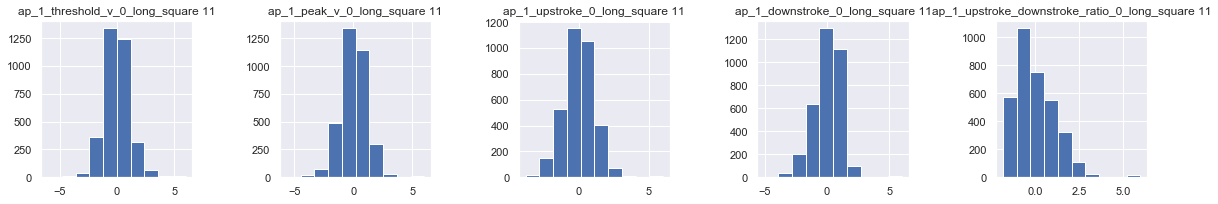

3 outliers in ap_1_width_0_long_square
1 outliers in ap_1_fast_trough_v_0_long_square


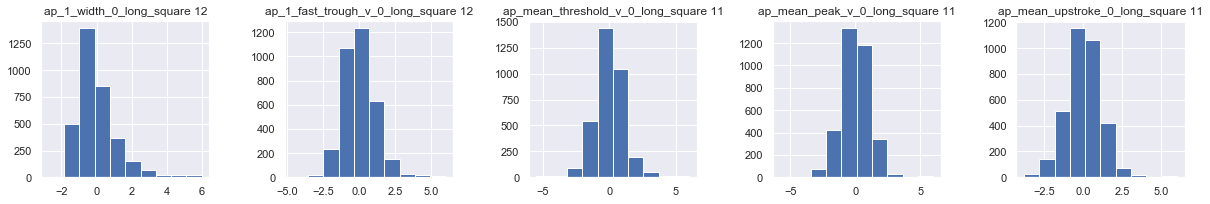

1 outliers in ap_mean_upstroke_downstroke_ratio_0_long_square
5 outliers in ap_mean_width_0_long_square
1 outliers in ap_mean_fast_trough_v_0_long_square
53 outliers in avg_rate_0_long_square


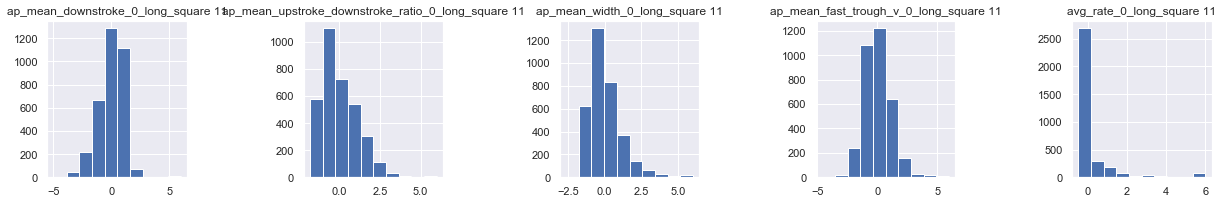

20 outliers in latency_0_long_square
5 outliers in fi_sqrt_fit_A
37 outliers in fi_sqrt_fit_Ic


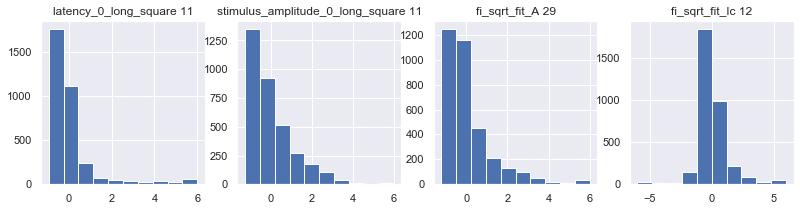

In [29]:
ncols = 5
i = 0
z_absmax = 6.0
n_outliers = 0
feature_mean = []
feature_std = []
for feature in keep_features:
    if i % ncols==0:
        plt.figure(figsize = (17,3))

    e = E_df[feature].copy()
    #Use middle percentile (ignores nans) to calculate means and std
    low = e.dropna().quantile(q=0.01)
    high = e.dropna().quantile(q=0.99)
    

    values = e[e.between(low,high)]
    e_mean = np.mean(values)
    e_std = np.std(values)
    e = (e-e_mean)/e_std
    feature_mean.append(e_mean)
    feature_std.append(e_std)
    
    #Set outliers to boundary
    num_set = (e.gt(z_absmax) | e.lt(-z_absmax)).sum()
    nanind = e.isna()
    e.fillna(10000,inplace=True) #avoiding issues with nans
    e[e > z_absmax]=z_absmax
    e[e < -z_absmax]=-z_absmax
    if num_set>0:
        print('{} outliers in {}'.format(num_set,feature))
    
    plt.subplot(1,ncols,i%ncols+1)
    plt.hist(e)
    e[nanind]=np.nan
    E_df[feature] = e
    
    ax = plt.gca()
    plt.title(feature+' '+str(e.isna().sum()))
    i = i+1
    if i % ncols==0:
        #On completing each row
        plt.tight_layout()
        plt.show()

In [30]:
#Write the ipfx features to dictionary
matdict['E_feature'] = E_df[keep_features].values
matdict['feature_names'] = np.array(keep_features)
matdict['feature_mean'] = np.array(feature_mean,dtype=float)
matdict['feature_std'] = np.array(feature_std,dtype=float)

In [31]:
#Remove samples with spc features that have no T data:
for k in matdict.keys(): 
    if '__' not in k:
        print('{:17s}: shape {}'.format(k,matdict[k].shape))

T_dat            : shape (3411, 1252)
T_spec_id_label  : shape (3411,)
T_ispaired       : shape (3411,)
gene_id          : shape (1252,)
cluster          : shape (3411,)
clusterID        : shape (3411,)
cluster_color    : shape (3411,)
sample_id        : shape (3411,)
map_conf         : shape (3411,)
E_dat            : shape (3708, 44)
E_spec_id_label  : shape (3708,)
E_ispaired       : shape (3708,)
spc_name         : shape (44,)
E_feature        : shape (3411, 34)
feature_names    : shape (34,)
feature_mean     : shape (34,)
feature_std      : shape (34,)


In [32]:
ind = np.isin(matdict['E_spec_id_label'],matdict['T_spec_id_label'])
matdict['E_dat'] = matdict['E_dat'][ind]
matdict['E_spec_id_label'] = matdict['E_spec_id_label'][ind]
matdict['E_ispaired'] = matdict['E_ispaired'][ind]
assert np.array_equal(matdict['E_spec_id_label'],matdict['T_spec_id_label']), 'Order is incorrect'

In [33]:
for k in matdict.keys(): 
    if '__' not in k:
        print('{:17s}: shape {}'.format(k,matdict[k].shape))

T_dat            : shape (3411, 1252)
T_spec_id_label  : shape (3411,)
T_ispaired       : shape (3411,)
gene_id          : shape (1252,)
cluster          : shape (3411,)
clusterID        : shape (3411,)
cluster_color    : shape (3411,)
sample_id        : shape (3411,)
map_conf         : shape (3411,)
E_dat            : shape (3411, 44)
E_spec_id_label  : shape (3411,)
E_ispaired       : shape (3411,)
spc_name         : shape (44,)
E_feature        : shape (3411, 34)
feature_names    : shape (34,)
feature_mean     : shape (34,)
feature_std      : shape (34,)


In [34]:
sio.savemat(base_path+'PS_v4_beta_0-4_allT_equalTE.mat',matdict,do_compression=True)

In [ ]:
#Tests
a = pd.DataFrame({'a1':['1','2','3','4'],'a2':['a','a','a','a']})
b = pd.DataFrame({'b1':['100','200','500','600'],'b2':['b','b','l','m']})
a.merge(b,how='left',left_on='a1',right_on='b1')